In [ ]:
# Run this cell first in Colab
!pip install yfinance --quiet
!pip install tensorflow --quiet

import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score, classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import datetime


In [ ]:
# Choose ticker and date range
ticker = "AAPL"            # change to e.g. "RELIANCE.NS" for NSE
start = "2015-01-01"
end = datetime.date.today().strftime("%Y-%m-%d")

df = yf.download(ticker, start=start, end=end)
df.to_csv(f"{ticker}_history.csv")
df.tail()


/tmp/ipython-input-3698038528.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end)
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2025-10-10,245.270004,256.380005,244.000000,254.940002,61999100
2025-10-13,247.660004,249.690002,245.559998,249.380005,38142900
2025-10-14,247.770004,248.850006,244.699997,246.600006,35478000
2025-10-15,249.339996,251.820007,247.470001,249.490005,33893600
2025-10-16,247.449997,249.039993,245.130005,248.250000,39698000


In [ ]:
print(df.info())
print(df.describe())


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2714 entries, 2015-01-02 to 2025-10-16
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   (Close, AAPL)   2714 non-null   float64
 1   (High, AAPL)    2714 non-null   float64
 2   (Low, AAPL)     2714 non-null   float64
 3   (Open, AAPL)    2714 non-null   float64
 4   (Volume, AAPL)  2714 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 127.2 KB
None
Price         Close         High          Low         Open        Volume
Ticker         AAPL         AAPL         AAPL         AAPL          AAPL
count   2714.000000  2714.000000  2714.000000  2714.000000  2.714000e+03
mean     103.250505   104.280175   102.115830   103.157577  1.126502e+08
std       71.431671    72.123459    70.652932    71.355781  6.802940e+07
min       20.624048    20.927672    20.425434    20.546423  2.323470e+07
25%       36.434848    36.760911    36.100875    36.465793  6.6220

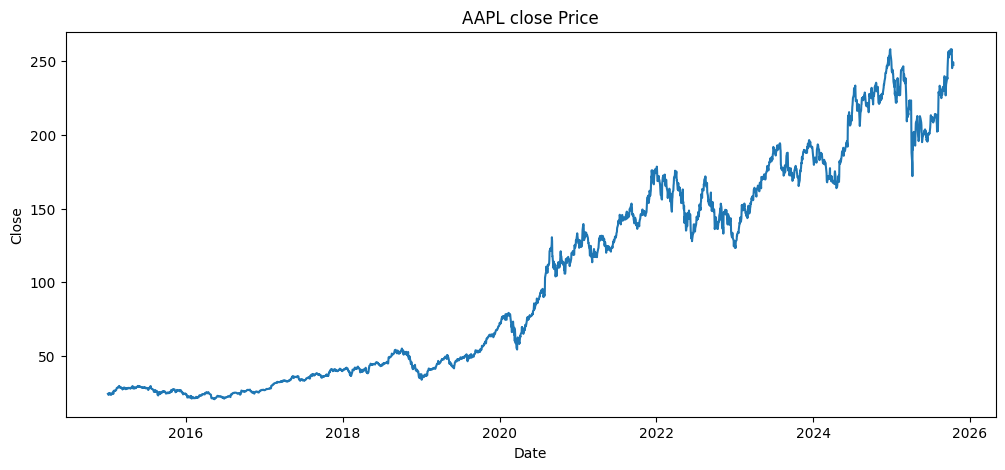

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(df['Close'])
plt.title(f"{ticker} close Price")
plt.xlabel("Date")
plt.ylabel("Close")
plt.show()

In [ ]:
#preprocessing : Create sequences for LSTM (Regression)

n_steps=60
test_ration=0.2
feature_col=['Close']

data=df[feature_col].copy()

#scale

scaler = MinMaxScaler()
scaled = scaler.fit_transform(data)

#bulid sequences

def create_sequences(data_array,n_steps):
  X,y=[],[]
  for i in range(n_steps,len(data_array)):
    X.append(data_array[i-n_steps:i])
    y.append(data_array[i,0])
  return np.array(X),np.array(y)

X,y = create_sequences(scaled,n_steps)
print("X shape:",X.shape,"y shape",y.shape)

X shape: (2654, 60, 1) y shape (2654,)


To prepare the data for classification, we need to create a target variable. A common approach is to predict whether the price will go up or down on the next day. We can create a new column, say 'up', which is 1 if the 'Close' price increased from the previous day and 0 otherwise.

In [ ]:
# Create a new column 'up' where 1 indicates the price went up and 0 indicates it went down or stayed the same
df['up'] = (df['Close'].shift(-1) > df['Close']).astype(int)

# Display the last few rows to see the new 'up' column
display(df.tail())

Price,Close,High,Low,Open,Volume,up
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,
Date,,,,,,
2025-10-10,245.270004,256.380005,244.000000,254.940002,61999100,1
2025-10-13,247.660004,249.690002,245.559998,249.380005,38142900,1
2025-10-14,247.770004,248.850006,244.699997,246.600006,35478000,1
2025-10-15,249.339996,251.820007,247.470001,249.490005,33893600,0
2025-10-16,247.449997,249.039993,245.130005,248.250000,39698000,0


Now that we have the 'up' column in our original `df` DataFrame, we can use it to create sequences for the classification model. We'll define a new function `create_sequences_with_labels` that takes the scaled data, the labels (our 'up' column), and the number of steps as input.

In [ ]:
# Create sequences for LSTM (Classification)

def create_sequences_with_labels(data_array, labels_array, n_steps):
    X, y = [], []
    for i in range(n_steps, len(data_array)):
        X.append(data_array[i-n_steps:i])
        y.append(labels_array[i]) # Use the corresponding label for the sequence
    return np.array(X), np.array(y)

# Assuming 'scaled' is the scaled data from the 'Close' prices and df['up'] are the labels
Xc, yc = create_sequences_with_labels(scaled, df['up'].values, n_steps)

print("Xc shape:", Xc.shape, "yc shape", yc.shape)

Xc shape: (2654, 60, 1) yc shape (2654,)


Finally, we'll split the classification data into training and testing sets, similar to how we did for the regression data.

In [ ]:
# Split classification data
split_idx_c = int((1 - test_ration) * Xc.shape[0])
Xc_train, Xc_test = Xc[:split_idx_c], Xc[split_idx_c:]
yc_train, yc_test = yc[:split_idx_c], yc[split_idx_c:]

print("Xc_train shape:", Xc_train.shape, "yc_train shape:", yc_train.shape)
print("Xc_test shape:", Xc_test.shape, "yc_test shape:", yc_test.shape)

Xc_train shape: (2123, 60, 1) yc_train shape: (2123,)
Xc_test shape: (531, 60, 1) yc_test shape: (531,)


In [ ]:
split_idx = int((1-test_ration)*X.shape[0])
X_train,X_test=X[:split_idx],X[split_idx:]
y_train,y_test=y[:split_idx],y[split_idx:]

print("X_train shape:",X_train.shape,"y_train shape:",y_train.shape)
print("X_test shape:",X_test.shape,"y_test shape:",y_test.shape)

X_train shape: (2123, 60, 1) y_train shape: (2123,)
X_test shape: (531, 60, 1) y_test shape: (531,)


In [ ]:
tf.keras.backend.clear_session()
clf=keras.Sequential([
  layers.LSTM(64,input_shape=(Xc_train.shape[1],Xc_train.shape[2])) ,
  layers.Dropout(0.2),
  layers.Dense(32,activation='relu'),
  layers.Dropout(0.2),
  layers.Dense(1,activation='sigmoid')
])

clf.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
clf.summary()



/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,009 (74.25 KB)

 Trainable params: 19,009 (74.25 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
es=keras.callbacks.EarlyStopping(monitor='val_loss',patience=8,restore_best_weights=True)

In [ ]:
history_clf=clf.fit(
    Xc_train,yc_train,
    epochs=100,
    batch_size=32,
    callbacks=[es]
)

Epoch 1/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.5238 - loss: 0.6929
Epoch 2/100
24/67 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5245 - loss: 0.6927

/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5283 - loss: 0.6922
Epoch 3/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5235 - loss: 0.6929
Epoch 4/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5466 - loss: 0.6903
Epoch 5/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5358 - loss: 0.6919
Epoch 6/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5397 - loss: 0.6919
Epoch 7/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5309 - loss: 0.6914
Epoch 8/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5321 - loss: 0.6913
Epoch 9/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5179 - loss: 0.6937
Epoch 10/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5264 - loss: 0.6922
Epoch 11/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5463 - loss: 0.6903
Epoch 12/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5222 - loss: 0.6921
Epoch 13/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5127 -

In [ ]:
# Evaluate
yc_pred_prob = clf.predict(Xc_test).ravel()
yc_pred = (yc_pred_prob >= 0.5).astype(int)
print("Accuracy:", accuracy_score(yc_test, yc_pred))
print(classification_report(yc_test, yc_pred))


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
Accuracy: 0.5084745762711864
              precision    recall  f1-score   support

           0       0.47      0.55      0.51       243
           1       0.56      0.47      0.51       288

    accuracy                           0.51       531
   macro avg       0.51      0.51      0.51       531
weighted avg       0.52      0.51      0.51       531

